In [592]:
%reset

# Football Predict
## Questions before start:
We have a bunch of csv files, where each one is divided into categories:
1. Country (belgium, england, france, germany, greece, italy, netherlands, portugal, scotland, spain, turkey)
2. League (0, 1, 2, 3)
3. Season (2000-2001, 2001-2002, ..., 2021-2022)

Should we merge all the csv files into one big dataframe? Or should we keep them separate? 
If we merge them, how do we keep track of the different leagues and seasons?  

## Thoughts:
We could merge them into one big dataframe, and provide analysis on the whole dataset. 
In case we need analyse a specific league or season, we can filter the dataframe accordingly.

**Before merging**, we should add a column for the league and season.


In [593]:
# TODO: 
#  1. try to find in what city match occurred (add as feature), and find related weather data for that city and day (as feature)
#  (DONE) 2. check if particular bookmaker appears only in one (or more) country 
#  (DONE) 3. check if particular bookmaker appears only in one (or more) league
#  (DONE) 4. add weekend/weekday as feature (as "Betting odds for weekend games are collected Friday afternoons, and on Tuesday afternoons for midweek games.")
#  5. add "number of days since last match" as feature
#  (DONE) 6. check correlations in odds across bookmakers, so that we can drop some columns (probably keep only one bookmaker)
#  7. Aggregated columns for bookmakers odds, (min, max, median, mean odd from bookmakers, make column with Interwetten + other so we don't have missing values).
#  8. see case study notebook for more ideas
#  9. split teams by name
#  10. statistical features based on previous matches (e.g. average goals scored in last 5 matches, average goals conceded in last 5 matches, etc.)
#  11. construct dataframe with all countries, split by league
#  12. input NAs (mean average)
#  13. Modeling: classification – Random Forest, Logistic Regression, SVM
#                regression – Random Forest, Linear Regression, Stepwise Regression, SVM
#  14. Compare models classification: by accuracy, precision, recall, F1 score, ROC curve, AUC
#                     regression: by RMSE, R2, MAE  




In [594]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [595]:
# csv_files = sorted(glob(f'data/train/**/*.csv', recursive=True))

def read_data(folder_path, mac=False):
    df = pd.DataFrame()
    separator = '/' if mac else '\\'

    for file_path in sorted(glob(f'{folder_path}{separator}**{separator}*.csv', recursive=True)):
        csv_file_df = pd.read_csv(file_path)

        # Rename HT and AT columns to HomeTeam and AwayTeam
        if 'HT' in csv_file_df.columns or 'AT' in csv_file_df.columns:
            csv_file_df.rename(columns={'HT': 'HomeTeam', 'AT': 'AwayTeam'}, inplace=True)

        # Extract country, league, and season from file path
        parts = file_path.split(separator)
        country = parts[-3]
        league = int(parts[-2])
        season = int(parts[-1].split('.')[0])

        # Add country, league, and season as features to the front
        csv_file_df.insert(0, 'Country', country)
        csv_file_df.insert(1, 'League', league)
        csv_file_df.insert(2, 'Season', season)

        # Convert date to datetime format and sort by date
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%y', errors='ignore')
        csv_file_df['Date'] = pd.to_datetime(csv_file_df['Date'], format='%d/%m/%Y', errors='coerce')
        csv_file_df = csv_file_df.sort_values(by='Date')

        # Determine if the game is on a weekend or weekday
        # Weekends are typically Saturday (5) and Sunday (6)
        csv_file_df['DayOfWeek'] = csv_file_df['Date'].dt.dayofweek
        csv_file_df['is_Weekend'] = csv_file_df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

        df = pd.concat([df, csv_file_df], ignore_index=True, axis=0, join='outer', sort=False)

    return df

In [596]:
# Read all training data
train_df = read_data('data/train', mac=True)

## Filter out matches before 1718 season

In [597]:
train_df = train_df[train_df['Season'] >= 1718]

In [598]:
# Display unique column names and their count
unique_columns = train_df.columns.unique()
column_count = len(unique_columns)

print("Unique Column Names:")
print(unique_columns)

print("\nNumber of Unique Columns:", column_count)

Unique Column Names:
Index(['Country', 'League', 'Season', 'Div', 'Date', 'HomeTeam', 'AwayTeam',
       'FTHG', 'FTAG', 'FTR',
       ...
       'Unnamed: 72', 'LB', 'LB.1', 'LB.2', 'Unnamed: 24', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 53', 'Unnamed: 106'],
      dtype='object', length=215)

Number of Unique Columns: 215


In [599]:
# Drop empty columns starting with "Unnamed"
train_df = train_df.filter(regex='^(?!Unnamed).*$')


## Column Dicts

In [600]:
# Split columns into categories about match (results data), Match Statistics, and betting odds (as in notes.txt)
# Rename columns later
match_data = {
    "DayOfWeek": "DayOfWeek",
    "Weekend": "Weekend",
    "League": "League",
    "Season": "Season",
    "Country": "Country",
    "Div": "League_Division",
    "Date": "Match_Date",
    "Time": "Time_of_match_kick_off",
    "HomeTeam": "Home_Team",
    "AwayTeam": "Away_Team",
    "FTHG": "Full_Time_Home_Team_Goals",
    "FTAG": "Full_Time_Away_Team_Goals",
    "FTR": "Full_Time_Result",
    "HTHG": "Half_Time_Home_Team_Goals",
    "HTAG": "Half_Time_Away_Team_Goals",
    "HTR": "Half_Time_Result"
}

match_statistics = {
    "Attendance": "Crowd_Attendance",
    "Referee": "Match_Referee",
    "HS": "Home_Team_Shots",
    "AS": "Away_Team_Shots",
    "HST": "Home_Team_Shots_on_Target",
    "AST": "Away_Team_Shots_on_Target",
    "HHW": "Home_Team_Hit_Woodwork",
    "AHW": "Away_Team_Hit_Woodwork",
    "HC": "Home_Team_Corners",
    "AC": "Away_Team_Corners",
    "HF": "Home_Team_Fouls_Committed",
    "AF": "Away_Team_Fouls_Committed",
    "HFKC": "Home_Team_Free_Kicks_Conceded",
    "AFKC": "Away_Team_Free_Kicks_Conceded",
    "HO": "Home_Team_Offsides",
    "AO": "Away_Team_Offsides",
    "HY": "Home_Team_Yellow_Cards",
    "AY": "Away_Team_Yellow_Cards",
    "HR": "Home_Team_Red_Cards",
    "AR": "Away_Team_Red_Cards",
    "HBP": "Home_Team_Bookings_Points",
    "ABP": "Away_Team_Bookings_Points"
}

betting_odds_1x2_match = {
    "B365H": "Bet365_home_win_odds",
    "B365D": "Bet365_draw_odds",
    "B365A": "Bet365_away_win_odds",
    "BSH": "Blue_Square_home_win_odds",
    "BSD": "Blue_Square_draw_odds",
    "BSA": "Blue_Square_away_win_odds",
    "BWH": "Bet&Win_home_win_odds",
    "BWD": "Bet&Win_draw_odds",
    "BWA": "Bet&Win_away_win_odds",
    "GBH": "Gamebookers_home_win_odds",
    "GBD": "Gamebookers_draw_odds",
    "GBA": "Gamebookers_away_win_odds",
    "IWH": "Interwetten_home_win_odds",
    "IWD": "Interwetten_draw_odds",
    "IWA": "Interwetten_away_win_odds",
    "LBH": "Ladbrokes_home_win_odds",
    "LBD": "Ladbrokes_draw_odds",
    "LBA": "Ladbrokes_away_win_odds",
    "PSH": "Pinnacle_home_win_odds",
    "PSD": "Pinnacle_draw_odds",
    "PSA": "Pinnacle_away_win_odds",
    "SOH": "Sporting_Odds_home_win_odds",
    "SOD": "Sporting_Odds_draw_odds",
    "SOA": "Sporting_Odds_away_win_odds",
    "SBH": "Sportingbet_home_win_odds",
    "SBD": "Sportingbet_draw_odds",
    "SBA": "Sportingbet_away_win_odds",
    "SJH": "Stan_James_home_win_odds",
    "SJD": "Stan_James_draw_odds",
    "SJA": "Stan_James_away_win_odds",
    "SYH": "Stanleybet_home_win_odds",
    "SYD": "Stanleybet_draw_odds",
    "SYA": "Stanleybet_away_win_odds",
    "VCH": "VC_Bet_home_win_odds",
    "VCD": "VC_Bet_draw_odds",
    "VCA": "VC_Bet_away_win_odds",
    "WHH": "William_Hill_home_win_odds",
    "WHD": "William_Hill_draw_odds",
    "WHA": "William_Hill_away_win_odds",
    "Bb1X2": "Number_of_BetBrain_bookmakers_used",
    "BbMxH": "Betbrain_maximum_home_win_odds",
    "BbAvH": "Betbrain_average_home_win_odds",
    "BbMxD": "Betbrain_maximum_draw_odds",
    "BbAvD": "Betbrain_average_draw_win_odds",
    "BbMxA": "Betbrain_maximum_away_win_odds",
    "BbAvA": "Betbrain_average_away_win_odds",
    "MaxH": "Market_maximum_home_win_odds",
    "MaxD": "Market_maximum_draw_win_odds",
    "MaxA": "Market_maximum_away_win_odds",
    "AvgH": "Market_average_home_win_odds",
    "AvgD": "Market_average_draw_win_odds",
    "AvgA": "Market_average_away_win_odds",
}

betting_odds_total_goals = {
    "BbOU": "Number_BetBrain_over_under_2.5_goals_averages_and_maximums",
    "BbMx>2.5": "Betbrain_maximum_over_2.5_goals",
    "BbAv>2.5": "Betbrain_average_over_2.5_goals",
    "BbMx<2.5": "Betbrain_maximum_under_2.5_goals",
    "BbAv<2.5": "Betbrain_average_under_2.5_goals",
    "GB>2.5": "Gamebookers_over_2.5_goals",
    "GB<2.5": "Gamebookers_under_2.5_goals",
    "B365>2.5": "Bet365_over_2.5_goals",
    "B365<2.5": "Bet365_under_2.5_goals",
    "P>2.5": "Pinnacle_over_2.5_goals",
    "P<2.5": "Pinnacle_under_2.5_goals",
    "Max>2.5": "Market_maximum_over_2.5_goals",
    "Max<2.5": "Market_maximum_under_2.5_goals",
    "Avg>2.5": "Market_average_over_2.5_goals",
    "Avg<2.5": "Market_average_under_2.5_goals",
}

betting_odds_asian_handicap = {
    "BbAH": "Number_BetBrain_handicap_averages_and_maximums",
    "BbAHh": "Betbrain_size_of_handicap_home_team",
    "AHh": "Market_size_handicap_home_team_since_2019/2020",
    "BbMxAHH": "Betbrain_maximum_Asian_handicap_home_team_odds",
    "BbAvAHH": "Betbrain_average_Asian_handicap_home_team_odds",
    "BbMxAHA": "Betbrain_maximum_Asian_handicap_away_team_odds",
    "BbAvAHA": "Betbrain_average_Asian_handicap_away_team_odds",
    "GBAHH": "Gamebookers_Asian_handicap_home_team_odds",
    "GBAHA": "Gamebookers_Asian_handicap_away_team_odds",
    "GBAH": "Gamebookers_size_of_handicap_home_team",
    "LBAHH": "Ladbrokes_Asian_handicap_home_team_odds",
    "LBAHA": "Ladbrokes_Asian_handicap_away_team_odds",
    "LBAH": "Ladbrokes_size_of_handicap_home_team",
    "B365AHH": "Bet365_Asian_handicap_home_team_odds",
    "B365AHA": "Bet365_Asian_handicap_away_team_odds",
    "B365AH": "Bet365_size_of_handicap_home_team",
    "PAHH": "Pinnacle_Asian_handicap_home_team_odds",
    "PAHA": "Pinnacle_Asian_handicap_away_team_odds",
    "MaxAHH": "Market_maximum_Asian_handicap_home_team_odds",
    "MaxAHA": "Market_maximum_Asian_handicap_away_team_odds",
    "AvgAHH": "Market_average_Asian_handicap_home_team_odds",
    "AvgAHA": "Market_average_Asian_handicap_away_team_odds",
}

closing_odds = {
    'AHCh': 'Market_size_handicap_home_team_since_2019/2020_close',
    'AvgC<2.5': 'Average_under_2.5_goals_close',
    'AvgC>2.5': 'Average_over_2.5_goals_close',
    'AvgCA': 'Away_win_odds_average_close',
    'AvgCAHA': 'Asian_handicap_away_team_odds_average_close',
    'AvgCAHH': 'Asian_handicap_home_team_odds_average_close',
    'AvgCD': 'Draw_odds_average_close',
    'AvgCH': 'Home_win_odds_average_close',
    'B365C<2.5': 'Bet365_under_2.5_goals_close',
    'B365C>2.5': 'Bet365_over_2.5_goals_close',
    'B365CA': 'Bet365_away_win_odds_close',
    'B365CAHA': 'Bet365_Asian_handicap_away_team_odds_close',
    'B365CAHH': 'Bet365_Asian_handicap_home_team_odds_close',
    'B365CD': 'Bet365_draw_odds_close',
    'B365CH': 'Bet365_home_win_odds_close',
    'BWCA': 'Bet&Win_away_win_odds_close',
    'BWCD': 'Bet&Win_draw_odds_close',
    'BWCH': 'Bet&Win_home_win_odds_close',
    'IWCA': 'Interwetten_away_win_odds_close',
    'IWCD': 'Interwetten_draw_odds_close',
    'IWCH': 'Interwetten_home_win_odds_close',
    'MaxC<2.5': 'Market_maximum_under_2.5_goals_close',
    'MaxC>2.5': 'Market_maximum_over_2.5_goals_close',
    'MaxCA': 'Market_maximum_away_win_odds_close',
    'MaxCAHA': 'Market_maximum_Asian_handicap_away_team_odds_close',
    'MaxCAHH': 'Market_maximum_Asian_handicap_home_team_odds_close',
    'MaxCD': 'Market_maximum_draw_odds_close',
    'MaxCH': 'Market_maximum_home_win_odds_close',
    'PC<2.5': 'Pinnacle_under_2.5_goals_close',
    'PC>2.5': 'Pinnacle_over_2.5_goals_close',
    'PCAHA': 'Pinnacle_Asian_handicap_away_team_odds_close',
    'PCAHH': 'Pinnacle_Asian_handicap_home_team_odds_close',
    'PSCA': 'Pinnacle_away_win_odds_close',
    'PSCD': 'Pinnacle_draw_odds_close',
    'PSCH': 'Pinnacle_home_win_odds_close',
    'VCCA': 'VC_Bet_away_win_odds_close',
    'VCCD': 'VC_Bet_draw_odds_close',
    'VCCH': 'VC_Bet_home_win_odds_close',
    'WHCA': 'William_Hill_away_win_odds_close',
    'WHCD': 'William_Hill_draw_odds_close',
    'WHCH': 'William_Hill_home_win_odds_close',
}


In [601]:
# Number of columns in each category
# Combine all sets
col_dicts = [
    betting_odds_asian_handicap,
    betting_odds_total_goals,
    betting_odds_1x2_match,
    match_statistics,
    match_data,
    closing_odds
]

# Calculate the total number of columns in dictionaries
num_col = sum(map(len, col_dicts))

print(f"Number of columns in train_df: {len(train_df.columns)}")
print(f"Number of documented columns: {num_col}")

Number of columns in train_df: 171
Number of documented columns: 168


In [602]:
# Combine all dictionary keys into a single set
col_dicts_keys = set().union(
    betting_odds_asian_handicap.keys(),
    betting_odds_total_goals.keys(),
    betting_odds_1x2_match.keys(),
    match_statistics.keys(),
    match_data.keys(),
    closing_odds.keys()
)

# Get the columns in train_df that are not in the combined set of keys
extra_columns = set(train_df.columns) - col_dicts_keys

# Display the extra columns
print("Columns not present in dictionaries:")
for column in extra_columns:
    print(column)


Columns not present in dictionaries:
LB.2
LB
LB.1


Maybe we should drop them, as we don't know what they are.

In [603]:
# Drop the extra columns
train_df = train_df.drop(columns=extra_columns)

Thought: each bookmaker might be assigned to one country, so we can add a column for the country of the bookmaker

In [604]:
# Rename columns in train_df according to the dictionaries
for col_dict in col_dicts:
    train_df.rename(columns=col_dict, inplace=True)
    
# Identify duplicate columns
duplicate_columns = train_df.columns[train_df.columns.duplicated()]

# Print the duplicate columns
print("Duplicate Columns:", duplicate_columns)

Duplicate Columns: Index([], dtype='object')


In [605]:
# 2. check if particular bookmaker appears only in one (or more) country
bookmakers = ['Bet365', 
              'Blue_Square', 
              'Bet&Win', 
              'Gamebookers', 
              'Interwetten',
              'Ladbrokes', 
              'Pinnacle', 
              'Sporting_Odds', 
              'Sportingbet', 
              'Stan_James',
              'Stanleybet', 
              'VC_Bet', 
              'William_Hill',
              'Betbrain']

df_test = train_df.copy()
# Create indicator columns for each bookmaker
for bookmaker in bookmakers:
    indicator_column = f'{bookmaker}_indicator'
    columns_to_check = [col for col in df_test.columns if bookmaker in col]
    df_test[indicator_column] = df_test[columns_to_check].any(axis=1).astype(int)

In [606]:
# List of indicator columns (replace this with your actual indicator columns)
indicator_columns = ['Bet365_indicator', 'Blue_Square_indicator', 'Bet&Win_indicator', 'Gamebookers_indicator',
                     'Interwetten_indicator', 'Ladbrokes_indicator', 'Pinnacle_indicator', 'Sporting_Odds_indicator',
                     'Sportingbet_indicator', 'Stan_James_indicator', 'Stanleybet_indicator', 'VC_Bet_indicator',
                     'William_Hill_indicator', 'Betbrain_indicator']


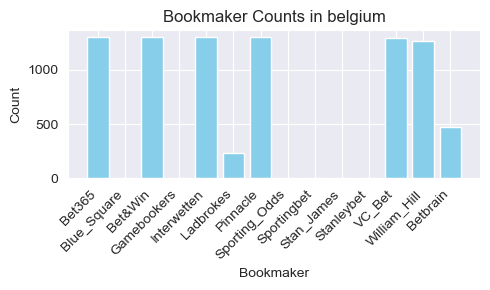

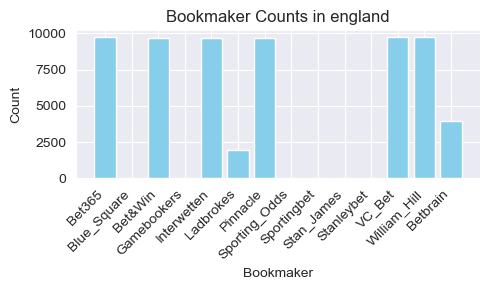

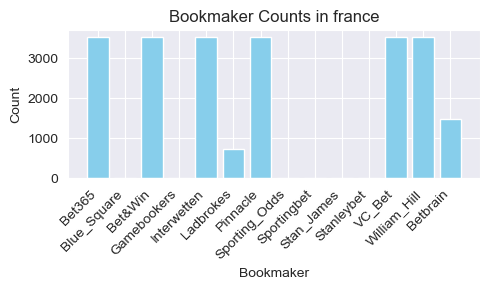

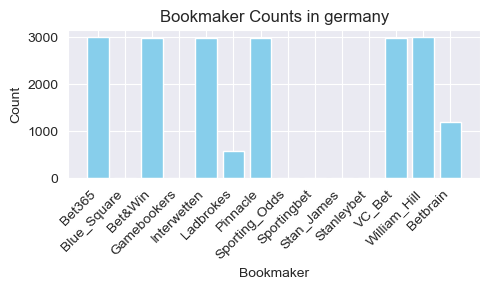

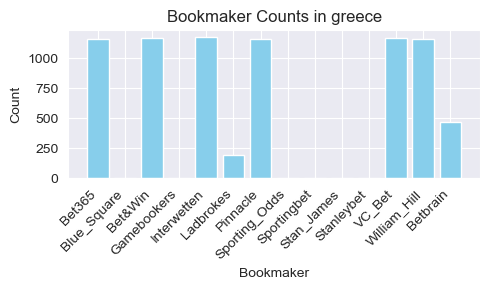

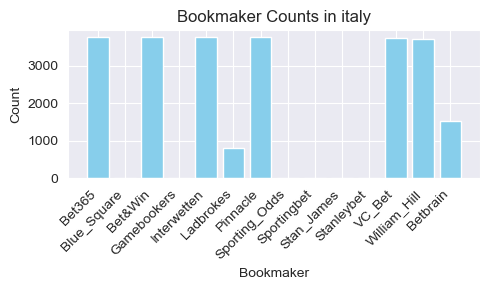

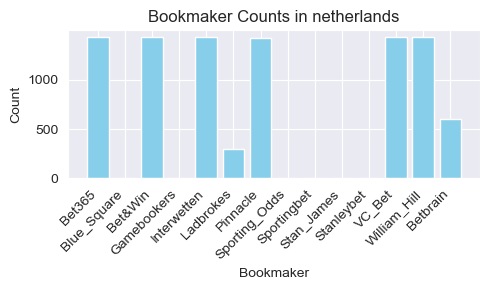

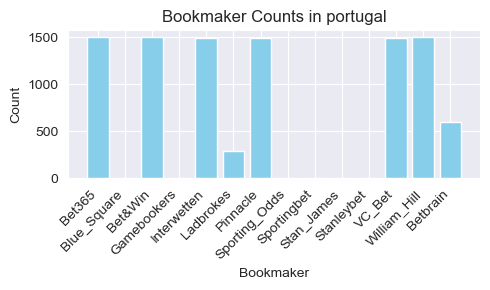

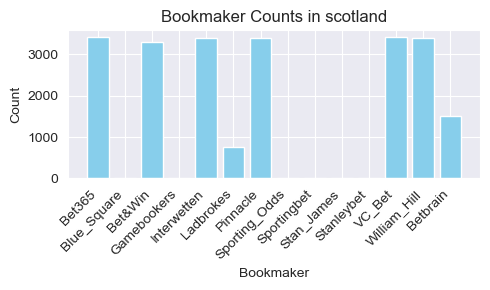

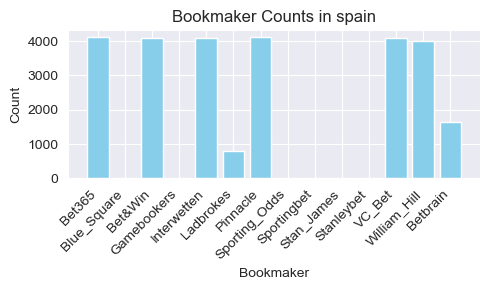

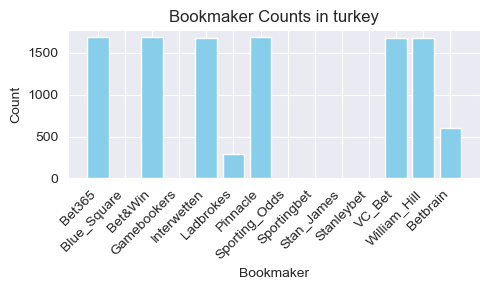

In [607]:
# Group by 'Country' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Country')[indicator_columns].sum().reset_index()

# Plot a bar chart for each country
for index, row in grouped_df.iterrows():
    country_name = row['Country']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {country_name}')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

There is no significant difference in bet distribution between the bookmakers per country.

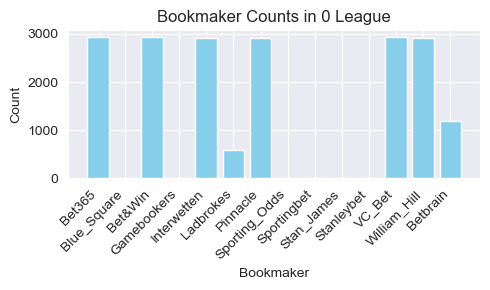

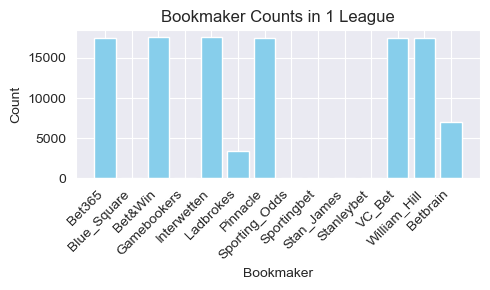

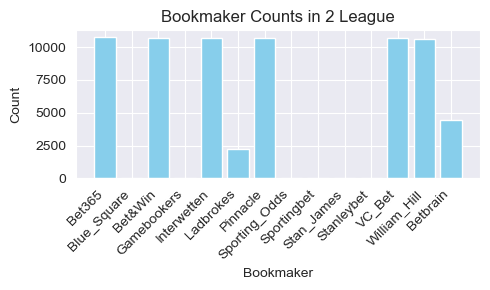

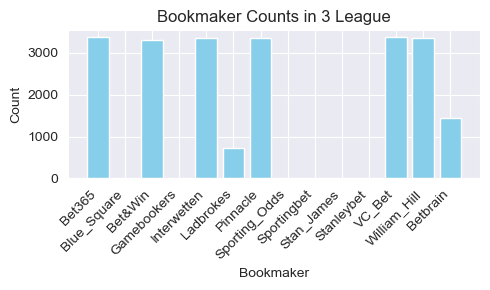

In [608]:
# Group by 'League' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('League')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['League']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} League')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

There is no significant difference in bet distribution between the bookmakers per league.

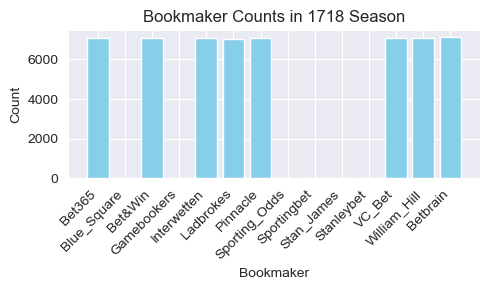

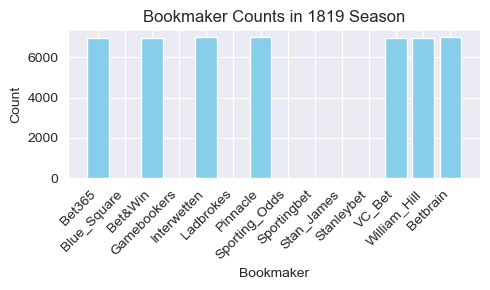

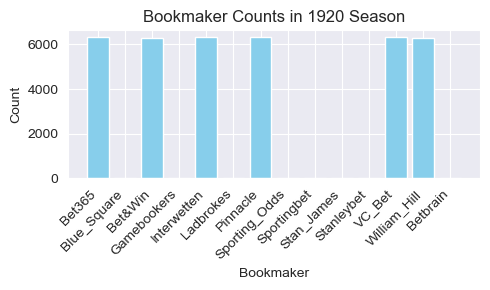

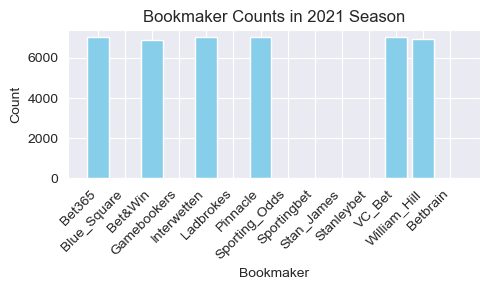

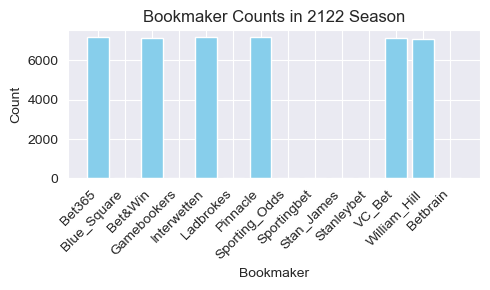

In [609]:
# Group by 'Season' and count the occurrences of 1 for each bookmaker
grouped_df = df_test.groupby('Season')[indicator_columns].sum().reset_index()

# Plot a bar chart for each league
for index, row in grouped_df.iterrows():
    league_name = row['Season']
    bookmaker_counts = row[indicator_columns].astype(int)
    bookmaker_name = [bkmkr.split('_indicator')[0] for bkmkr in indicator_columns]

    plt.figure(figsize=(5, 3))
    plt.bar(bookmaker_name, bookmaker_counts, color='skyblue')
    plt.title(f'Bookmaker Counts in {league_name} Season')
    plt.xlabel('Bookmaker')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.show()

## Bookmakers odds corelation


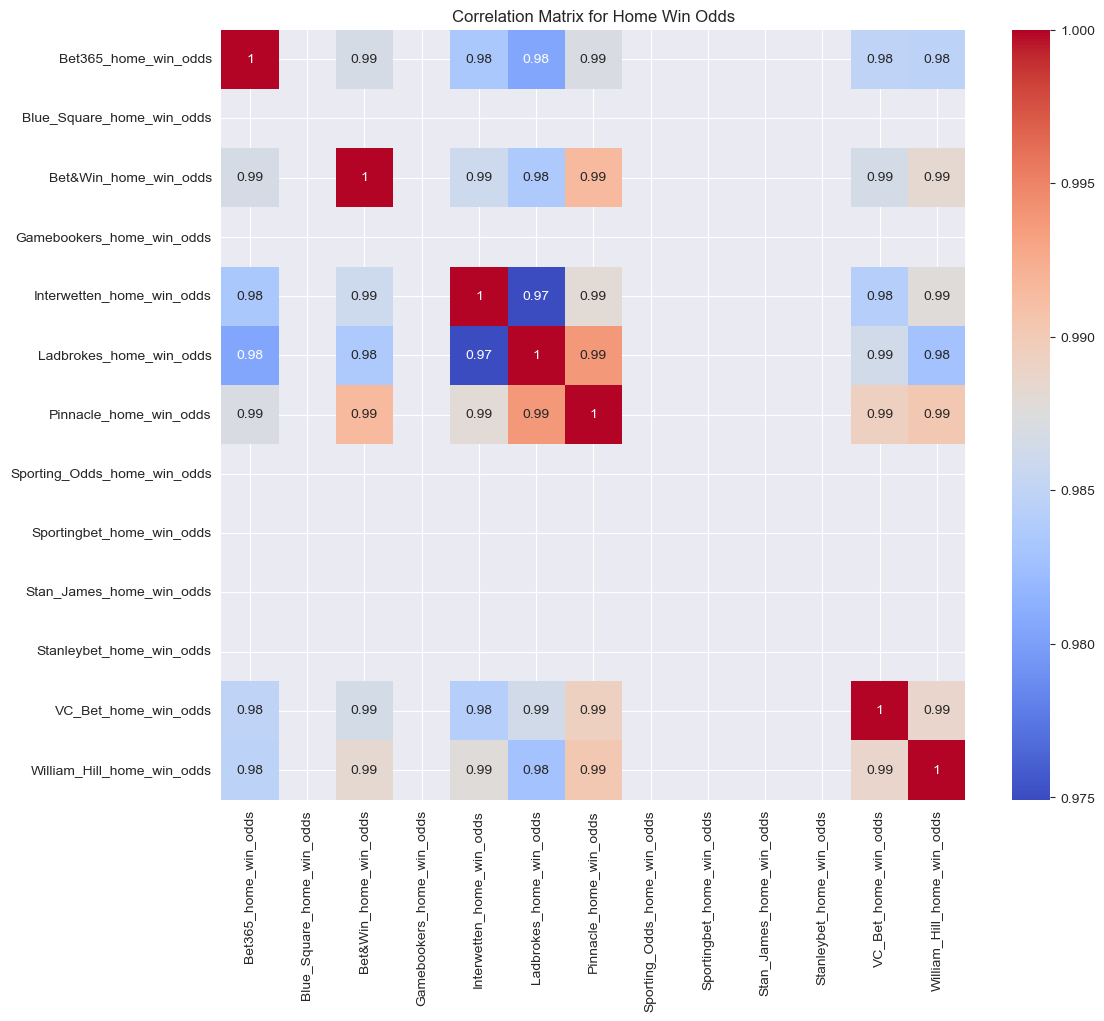

In [610]:

# Selecting home win odds from different bookmakers as an example
home_win_odds_columns = [
    "Bet365_home_win_odds", "Blue_Square_home_win_odds", "Bet&Win_home_win_odds",
    "Gamebookers_home_win_odds", "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds", "Sporting_Odds_home_win_odds", "Sportingbet_home_win_odds",
    "Stan_James_home_win_odds", "Stanleybet_home_win_odds", "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds"
]

# Compute the correlation matrix for home win odds
correlation_matrix_home_win = train_df[home_win_odds_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_home_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Home Win Odds')
plt.show()



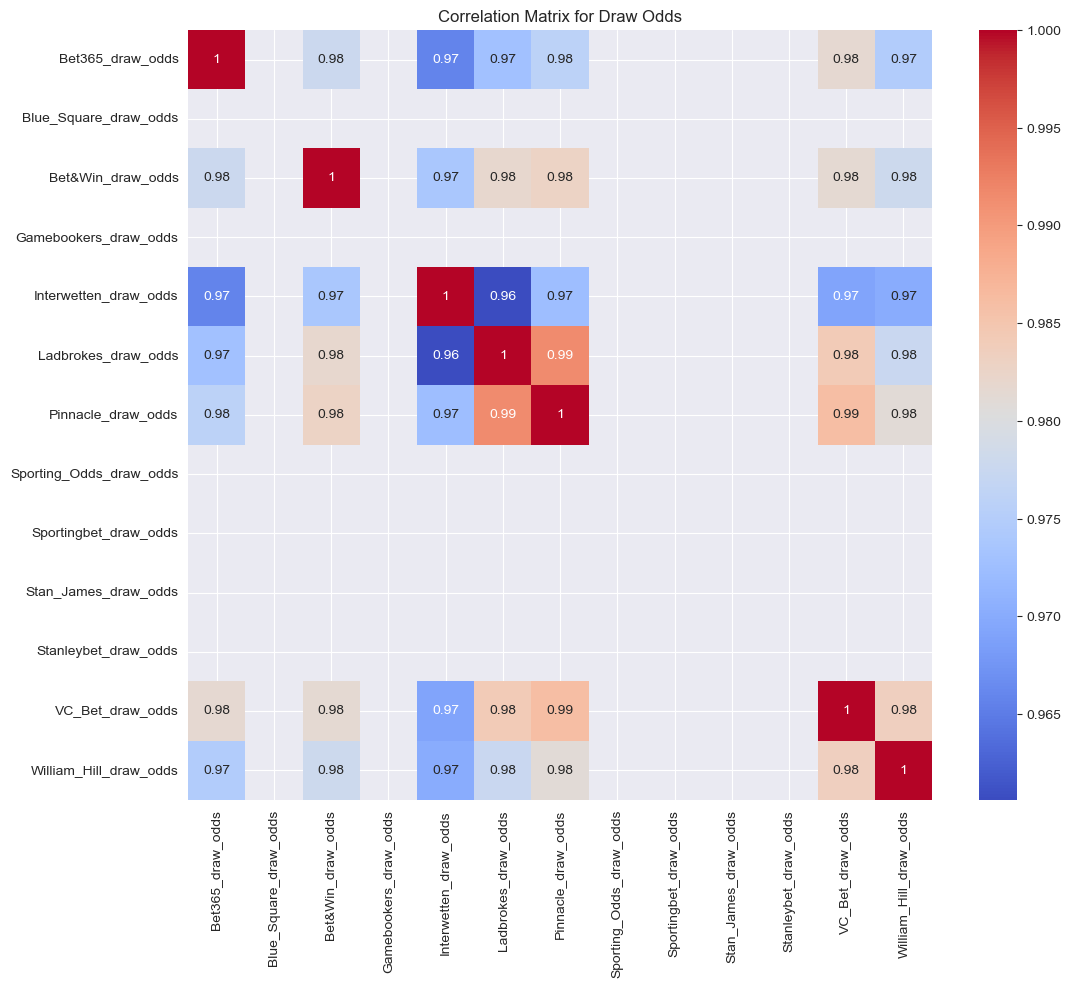

In [611]:
# Selecting draw odds from different bookmakers
draw_odds_columns = [
    "Bet365_draw_odds", "Blue_Square_draw_odds", "Bet&Win_draw_odds",
    "Gamebookers_draw_odds", "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "Sporting_Odds_draw_odds", "Sportingbet_draw_odds",
    "Stan_James_draw_odds", "Stanleybet_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds"
]

# Compute the correlation matrix for draw odds
correlation_matrix_draw = train_df[draw_odds_columns].corr()

# Generate a heatmap of the correlation matrix for draw odds
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_draw, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Draw Odds')
plt.show()


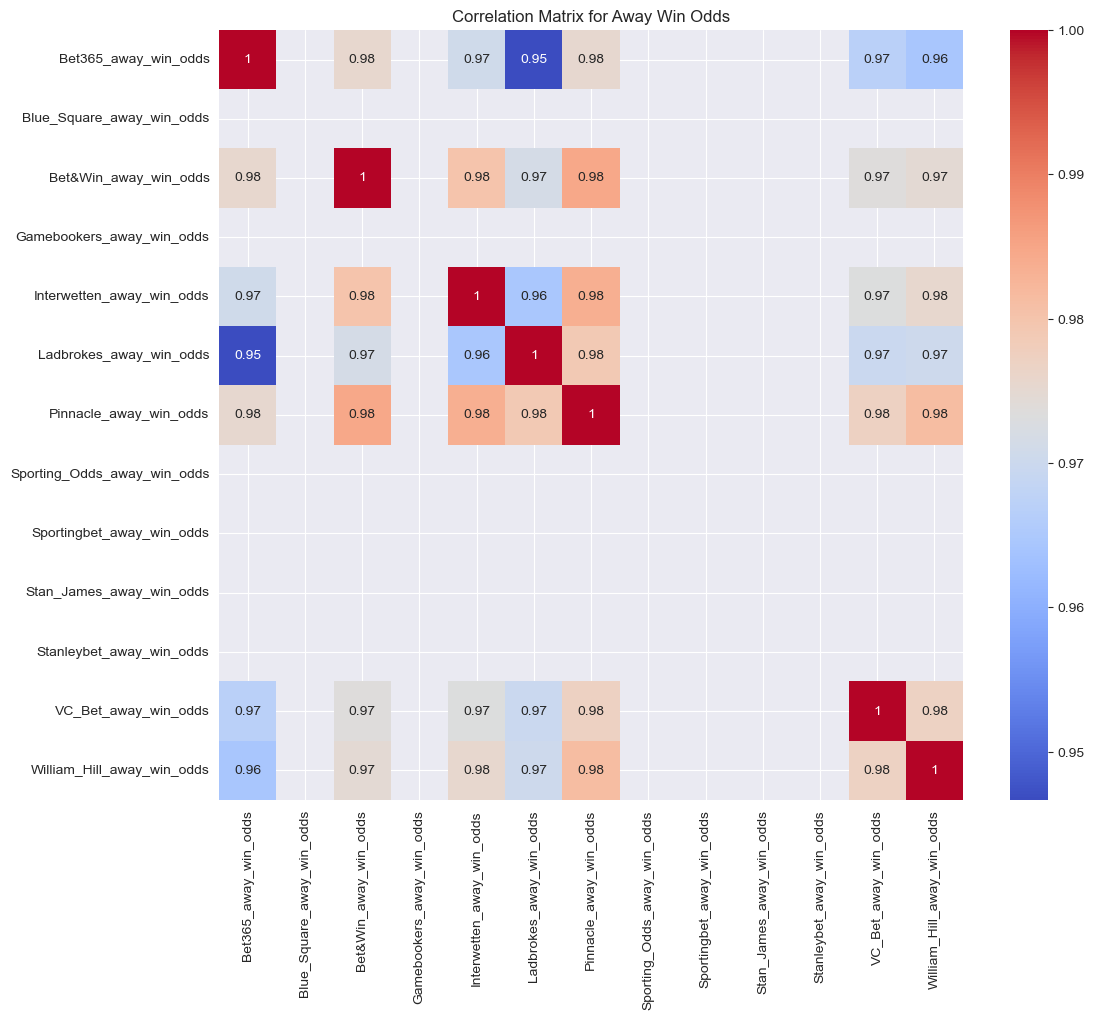

In [612]:
# Selecting away win odds from different bookmakers
away_win_odds_columns = [
    "Bet365_away_win_odds", "Blue_Square_away_win_odds", "Bet&Win_away_win_odds",
    "Gamebookers_away_win_odds", "Interwetten_away_win_odds", "Ladbrokes_away_win_odds",
    "Pinnacle_away_win_odds", "Sporting_Odds_away_win_odds", "Sportingbet_away_win_odds",
    "Stan_James_away_win_odds", "Stanleybet_away_win_odds", "VC_Bet_away_win_odds",
    "William_Hill_away_win_odds"
]

# Compute the correlation matrix for away win odds
correlation_matrix_away_win = train_df[away_win_odds_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_away_win, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Away Win Odds')
plt.show()


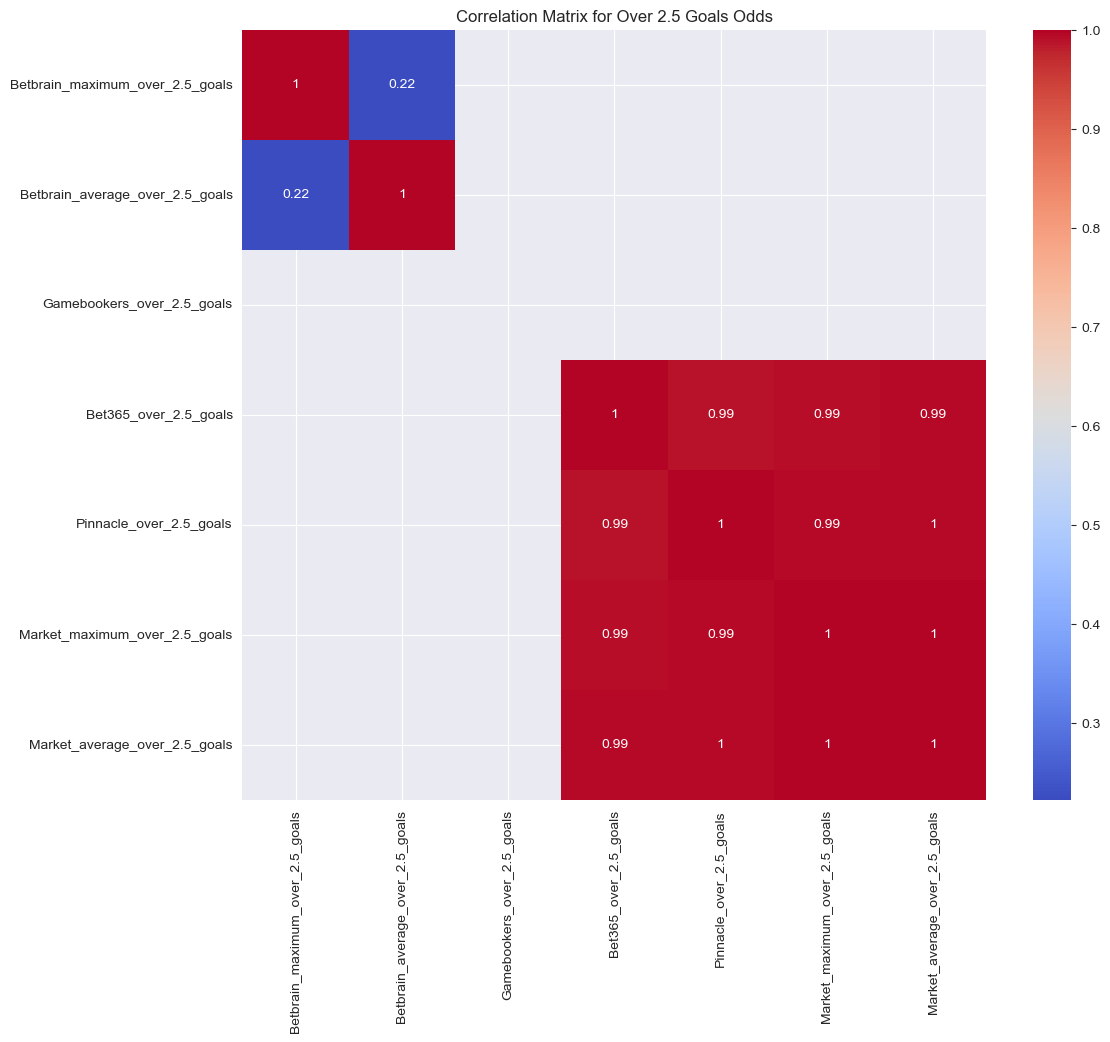

In [613]:
# Selecting over 2.5 goals odds from different bookmakers
over_2_5_goals_columns = [
    "Betbrain_maximum_over_2.5_goals", "Betbrain_average_over_2.5_goals",
    "Gamebookers_over_2.5_goals", "Bet365_over_2.5_goals",
    "Pinnacle_over_2.5_goals", "Market_maximum_over_2.5_goals",
    "Market_average_over_2.5_goals"
]

# Compute the correlation matrix for over 2.5 goals odds
correlation_matrix_over_2_5_goals = train_df[over_2_5_goals_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_over_2_5_goals, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Over 2.5 Goals Odds')
plt.show()


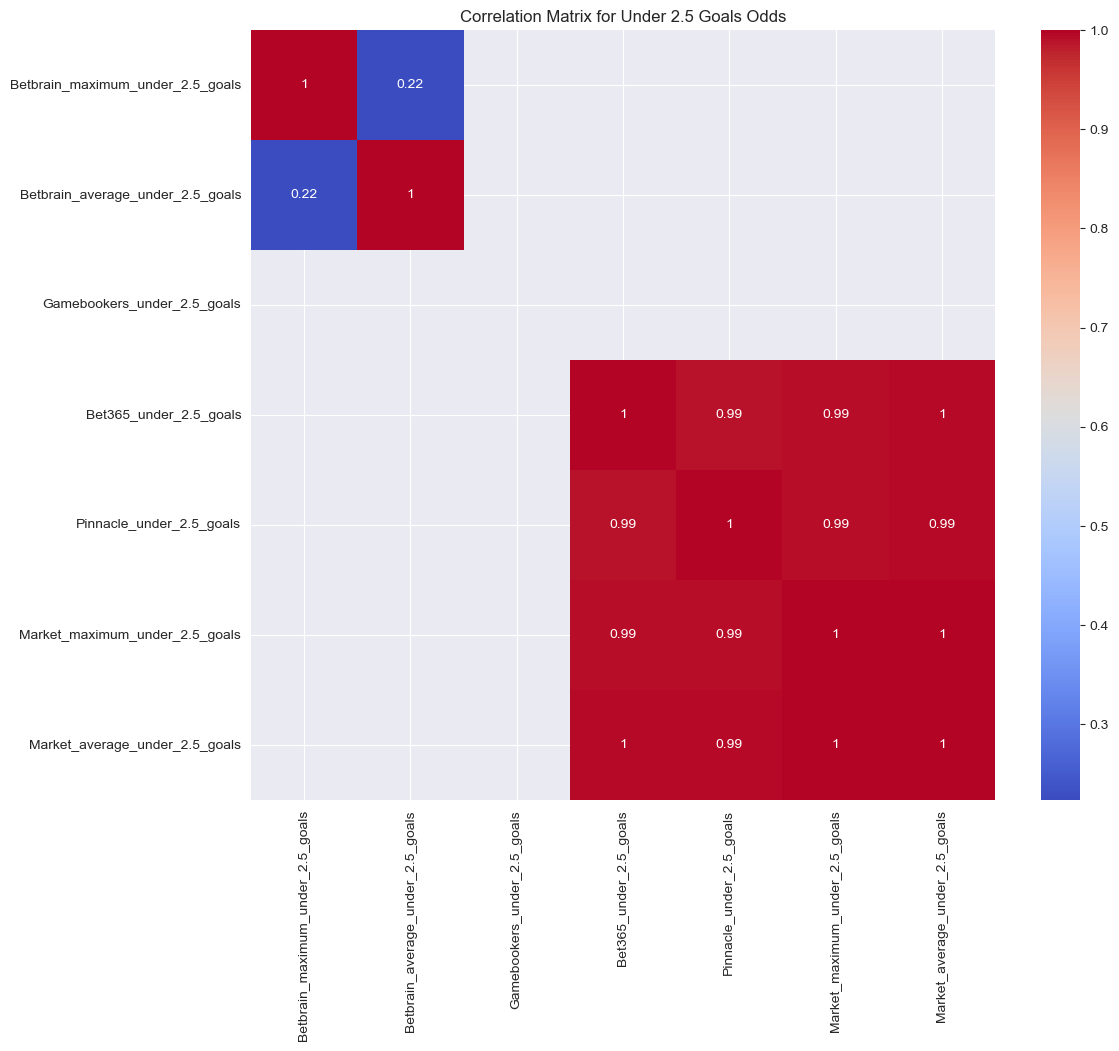

In [614]:
# Selecting under 2.5 goals odds from different bookmakers
under_2_5_goals_columns = [
    "Betbrain_maximum_under_2.5_goals", "Betbrain_average_under_2.5_goals",
    "Gamebookers_under_2.5_goals", "Bet365_under_2.5_goals",
    "Pinnacle_under_2.5_goals", "Market_maximum_under_2.5_goals",
    "Market_average_under_2.5_goals"
]

# Compute the correlation matrix for under 2.5 goals odds
correlation_matrix_under_2_5_goals = train_df[under_2_5_goals_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_under_2_5_goals, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Under 2.5 Goals Odds')
plt.show()


/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/2027020004.py:17: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_asian_handicap = train_df[asian_handicap_columns].corr()


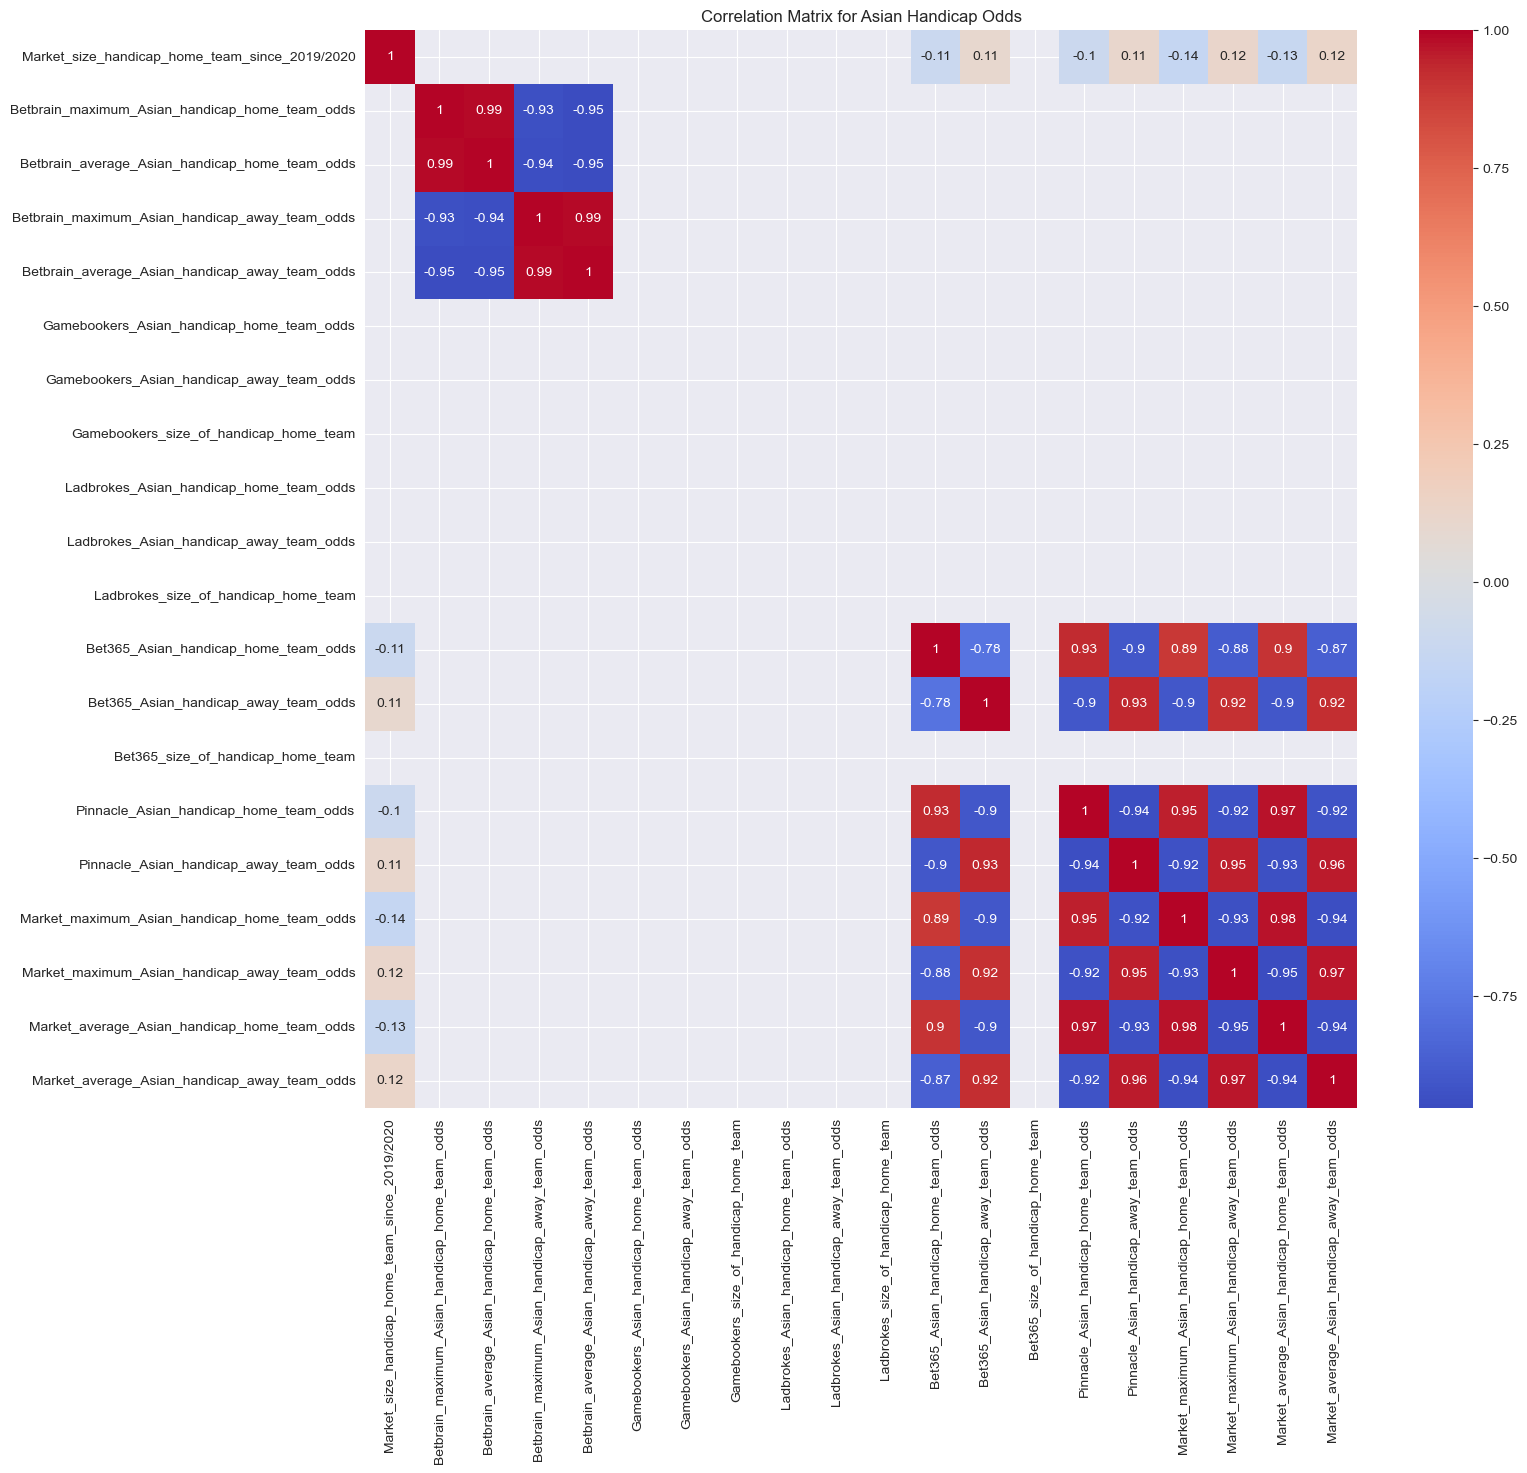

In [615]:
# Selecting Asian handicap odds from different bookmakers
asian_handicap_columns = [
    "Betbrain_size_of_handicap_home_team", "Market_size_handicap_home_team_since_2019/2020",
    "Betbrain_maximum_Asian_handicap_home_team_odds", "Betbrain_average_Asian_handicap_home_team_odds",
    "Betbrain_maximum_Asian_handicap_away_team_odds", "Betbrain_average_Asian_handicap_away_team_odds",
    "Gamebookers_Asian_handicap_home_team_odds", "Gamebookers_Asian_handicap_away_team_odds",
    "Gamebookers_size_of_handicap_home_team", "Ladbrokes_Asian_handicap_home_team_odds",
    "Ladbrokes_Asian_handicap_away_team_odds", "Ladbrokes_size_of_handicap_home_team",
    "Bet365_Asian_handicap_home_team_odds", "Bet365_Asian_handicap_away_team_odds",
    "Bet365_size_of_handicap_home_team", "Pinnacle_Asian_handicap_home_team_odds",
    "Pinnacle_Asian_handicap_away_team_odds", "Market_maximum_Asian_handicap_home_team_odds",
    "Market_maximum_Asian_handicap_away_team_odds", "Market_average_Asian_handicap_home_team_odds",
    "Market_average_Asian_handicap_away_team_odds"
]

# Compute the correlation matrix for Asian handicap odds
correlation_matrix_asian_handicap = train_df[asian_handicap_columns].corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix_asian_handicap, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Asian Handicap Odds')
plt.show()


## Feature engineering

### Aggregated columns for bookmakers

In [616]:
# Define the columns for home win, away win, and draw odds
home_win_columns = [
    "Bet365_home_win_odds", "Blue_Square_home_win_odds", "Bet&Win_home_win_odds",
    "Gamebookers_home_win_odds", "Interwetten_home_win_odds", "Ladbrokes_home_win_odds",
    "Pinnacle_home_win_odds", "Sporting_Odds_home_win_odds", "Sportingbet_home_win_odds",
    "Stan_James_home_win_odds", "Stanleybet_home_win_odds", "VC_Bet_home_win_odds",
    "William_Hill_home_win_odds", "Betbrain_average_home_win_odds"
]

away_win_columns = [
    "Bet365_away_win_odds", "Blue_Square_away_win_odds", "Bet&Win_away_win_odds",
    "Gamebookers_away_win_odds", "Interwetten_away_win_odds", "Ladbrokes_away_win_odds",
    "Pinnacle_away_win_odds", "Sporting_Odds_away_win_odds", "Sportingbet_away_win_odds",
    "Stan_James_away_win_odds", "Stanleybet_away_win_odds", "VC_Bet_away_win_odds",
    "William_Hill_away_win_odds", "Betbrain_average_away_win_odds"
]

draw_columns = [
    "Bet365_draw_odds", "Blue_Square_draw_odds", "Bet&Win_draw_odds",
    "Gamebookers_draw_odds", "Interwetten_draw_odds", "Ladbrokes_draw_odds",
    "Pinnacle_draw_odds", "Sporting_Odds_draw_odds", "Sportingbet_draw_odds",
    "Stan_James_draw_odds", "Stanleybet_draw_odds", "VC_Bet_draw_odds",
    "William_Hill_draw_odds", "Betbrain_average_draw_win_odds"
]

# Create new features for average home win, away win, and draw odds
train_df["Average_home_win_odds"] = train_df[home_win_columns].mean(axis=1, skipna=True)
train_df["Average_away_win_odds"] = train_df[away_win_columns].mean(axis=1, skipna=True)
train_df["Average_draw_odds"] = train_df[draw_columns].mean(axis=1, skipna=True)

# Display the updated DataFrame with new features
print(train_df.head())

      Country  League  Season League_Division Match_Date  Home_Team  \
4520  belgium       1    1718              B1 2017-07-28    Antwerp   
4521  belgium       1    1718              B1 2017-07-29      Eupen   
4522  belgium       1    1718              B1 2017-07-29  Charleroi   
4523  belgium       1    1718              B1 2017-07-29       Genk   
4524  belgium       1    1718              B1 2017-07-29    Lokeren   

             Away_Team  Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals  \
4520        Anderlecht                        0.0                        0.0   
4521           Waregem                        0.0                        5.0   
4522          Kortrijk                        1.0                        0.0   
4523  Waasland-Beveren                        3.0                        3.0   
4524       Club Brugge                        0.0                        4.0   

     Full_Time_Result  ...  Away_Team_Bookings_Points  \
4520                D  ...         

In [617]:
print("Missing values in Average_home_win_odds:", train_df['Average_home_win_odds'].isna().sum())
print("Missing values in Average_away_win_odds:", train_df['Average_away_win_odds'].isna().sum())
print("Missing values in Average_draw_odds:", train_df['Average_draw_odds'].isna().sum())

Missing values in Average_home_win_odds: 37
Missing values in Average_away_win_odds: 37
Missing values in Average_draw_odds: 37


In [618]:
# Drop the original bookmaker odds columns
train_df = train_df.drop(columns=betting_odds_1x2_match.values())

In [619]:
# Define the columns for over 2.5 goals odds
over_2_5_goals_columns = [
    "Betbrain_average_over_2.5_goals",
    "Gamebookers_over_2.5_goals", "Bet365_over_2.5_goals",
    "Pinnacle_over_2.5_goals", "Market_average_over_2.5_goals"
]

# Create new feature for average over 2.5 goals odds
train_df["Average_over_2.5_goals"] = train_df[over_2_5_goals_columns].mean(axis=1, skipna=True)

# Display the updated DataFrame with new feature
print(train_df.head())

      Country  League  Season League_Division Match_Date  Home_Team  \
4520  belgium       1    1718              B1 2017-07-28    Antwerp   
4521  belgium       1    1718              B1 2017-07-29      Eupen   
4522  belgium       1    1718              B1 2017-07-29  Charleroi   
4523  belgium       1    1718              B1 2017-07-29       Genk   
4524  belgium       1    1718              B1 2017-07-29    Lokeren   

             Away_Team  Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals  \
4520        Anderlecht                        0.0                        0.0   
4521           Waregem                        0.0                        5.0   
4522          Kortrijk                        1.0                        0.0   
4523  Waasland-Beveren                        3.0                        3.0   
4524       Club Brugge                        0.0                        4.0   

     Full_Time_Result  ...  Away_Team_Offsides  Home_Team_Bookings_Points  \
4520           

In [620]:
print("Missing values in Average_over_2.5_goals:", train_df['Average_over_2.5_goals'].isna().sum())

Missing values in Average_over_2.5_goals: 53


In [621]:
# Define the columns for under 2.5 goals odds
under_2_5_goals_columns = [
    "Betbrain_average_under_2.5_goals",
    "Gamebookers_under_2.5_goals", "Bet365_under_2.5_goals",
    "Pinnacle_under_2.5_goals", "Market_average_under_2.5_goals"
]

# Create new feature for average under 2.5 goals odds
train_df["Average_under_2.5_goals"] = train_df[under_2_5_goals_columns].mean(axis=1, skipna=True)

# Display the updated DataFrame with new feature
print(train_df.head())


      Country  League  Season League_Division Match_Date  Home_Team  \
4520  belgium       1    1718              B1 2017-07-28    Antwerp   
4521  belgium       1    1718              B1 2017-07-29      Eupen   
4522  belgium       1    1718              B1 2017-07-29  Charleroi   
4523  belgium       1    1718              B1 2017-07-29       Genk   
4524  belgium       1    1718              B1 2017-07-29    Lokeren   

             Away_Team  Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals  \
4520        Anderlecht                        0.0                        0.0   
4521           Waregem                        0.0                        5.0   
4522          Kortrijk                        1.0                        0.0   
4523  Waasland-Beveren                        3.0                        3.0   
4524       Club Brugge                        0.0                        4.0   

     Full_Time_Result  ...  Home_Team_Bookings_Points  \
4520                D  ...         

In [622]:
print("Missing values in Average_under_2.5_goals:", train_df['Average_under_2.5_goals'].isna().sum())

Missing values in Average_under_2.5_goals: 37


In [623]:
train_df = train_df.drop(columns=betting_odds_total_goals.values())

In [624]:
# Define the Asian handicap columns
asian_handicap_columns = betting_odds_asian_handicap.values()

# Split columns by home and away
home_asian_handicap = [
    col for col in asian_handicap_columns if ("home" in col.lower() and "maximum" not in col.lower())
]

away_asian_handicap = [
    col for col in asian_handicap_columns if ("away" in col.lower() and "maximum" not in col.lower())
]

# Create new features for average Asian handicap odds for home and away
train_df["Average_Asian_Handicap_Home"] = train_df[home_asian_handicap].mean(axis=1, skipna=True)
train_df["Average_Asian_Handicap_Away"] = train_df[away_asian_handicap].mean(axis=1, skipna=True)

# Display the updated DataFrame with new features
print(train_df.head())


      Country  League  Season League_Division Match_Date  Home_Team  \
4520  belgium       1    1718              B1 2017-07-28    Antwerp   
4521  belgium       1    1718              B1 2017-07-29      Eupen   
4522  belgium       1    1718              B1 2017-07-29  Charleroi   
4523  belgium       1    1718              B1 2017-07-29       Genk   
4524  belgium       1    1718              B1 2017-07-29    Lokeren   

             Away_Team  Full_Time_Home_Team_Goals  Full_Time_Away_Team_Goals  \
4520        Anderlecht                        0.0                        0.0   
4521           Waregem                        0.0                        5.0   
4522          Kortrijk                        1.0                        0.0   
4523  Waasland-Beveren                        3.0                        3.0   
4524       Club Brugge                        0.0                        4.0   

     Full_Time_Result  ...  Ladbrokes_Asian_handicap_home_team_odds  \
4520                D

In [625]:
print("Missing values in Average_Asian_Handicap_Home:", train_df['Average_Asian_Handicap_Home'].isna().sum())
print("Missing values in Average_Asian_Handicap_Away:", train_df['Average_Asian_Handicap_Away'].isna().sum())

Missing values in Average_Asian_Handicap_Home: 37
Missing values in Average_Asian_Handicap_Away: 37


In [626]:
train_df = train_df.drop(columns=betting_odds_asian_handicap.values())

In [627]:
train_df[closing_odds.values()].isna().sum()

Market_size_handicap_home_team_since_2019/2020_close    14121
Average_under_2.5_goals_close                           14105
Average_over_2.5_goals_close                            14105
Away_win_odds_average_close                             14121
Asian_handicap_away_team_odds_average_close             14125
Asian_handicap_home_team_odds_average_close             14105
Draw_odds_average_close                                 14105
Home_win_odds_average_close                             14116
Bet365_under_2.5_goals_close                            14135
Bet365_over_2.5_goals_close                             14160
Bet365_away_win_odds_close                              14131
Bet365_Asian_handicap_away_team_odds_close              14155
Bet365_Asian_handicap_home_team_odds_close              14155
Bet365_draw_odds_close                                  14131
Bet365_home_win_odds_close                              14145
Bet&Win_away_win_odds_close                             14244
Bet&Win_

Most of the columns have more than 40% missing values, so we will drop them. Keep only Pinnacle closing odds.

In [628]:
train_df['Close_home_win_odds'] = train_df['Pinnacle_home_win_odds_close']
train_df['Close_draw_odds'] = train_df['Pinnacle_draw_odds_close']
train_df['Close_away_win_odds'] = train_df['Pinnacle_away_win_odds_close']
train_df = train_df.drop(columns=closing_odds.values())

## Split dataset by league

In [629]:
train_df['Time_of_match_kick_off'] = pd.to_datetime(train_df['Time_of_match_kick_off'], format='%H:%M')

In [630]:
df_league_0 = train_df[train_df['League'] == 0]
df_league_1 = train_df[train_df['League'] == 1]
df_league_2 = train_df[train_df['League'] == 2]
df_league_3 = train_df[train_df['League'] == 3]

In [631]:
def print_missing_values_summary(df, league_name):
    print(f"\nLeague: {league_name}")
    print("Number of rows:", df.shape[0])

    missing_values = df.isnull().sum()
    total_cells = df.shape[0]
    na_percent = round((missing_values / total_cells) * 100, 2)

    summary_df = pd.DataFrame({
        'column_name': missing_values.index,
        'NA_count': missing_values.values,
        'NA_percent': na_percent.values
    })

    print(summary_df)

### Missing values summary

In [632]:
# Print missing values summary for each league
print_missing_values_summary(df_league_0, 0)


League: 0
Number of rows: 2927
                      column_name  NA_count  NA_percent
0                         Country         0        0.00
1                          League         0        0.00
2                          Season         0        0.00
3                 League_Division         0        0.00
4                      Match_Date         7        0.24
5                       Home_Team         0        0.00
6                       Away_Team         0        0.00
7       Full_Time_Home_Team_Goals         7        0.24
8       Full_Time_Away_Team_Goals         0        0.00
9                Full_Time_Result         0        0.00
10      Half_Time_Home_Team_Goals         0        0.00
11      Half_Time_Away_Team_Goals         0        0.00
12               Half_Time_Result        11        0.38
13                      DayOfWeek         7        0.24
14                        Weekend         0        0.00
15                Home_Team_Shots         0        0.00
16              

In [633]:
print_missing_values_summary(df_league_1, 1)


League: 1
Number of rows: 17563
                      column_name  NA_count  NA_percent
0                         Country         0        0.00
1                          League         0        0.00
2                          Season         0        0.00
3                 League_Division         0        0.00
4                      Match_Date         0        0.00
5                       Home_Team         7        0.04
6                       Away_Team         0        0.00
7       Full_Time_Home_Team_Goals         1        0.01
8       Full_Time_Away_Team_Goals        24        0.14
9                Full_Time_Result         1        0.01
10      Half_Time_Home_Team_Goals        15        0.09
11      Half_Time_Away_Team_Goals         4        0.02
12               Half_Time_Result        27        0.15
13                      DayOfWeek         0        0.00
14                        Weekend         0        0.00
15                Home_Team_Shots         6        0.03
16             

In [634]:
print_missing_values_summary(df_league_2, 2)


League: 2
Number of rows: 10759
                      column_name  NA_count  NA_percent
0                         Country         0        0.00
1                          League         0        0.00
2                          Season         0        0.00
3                 League_Division         0        0.00
4                      Match_Date        27        0.25
5                       Home_Team         0        0.00
6                       Away_Team         0        0.00
7       Full_Time_Home_Team_Goals        11        0.10
8       Full_Time_Away_Team_Goals         0        0.00
9                Full_Time_Result         0        0.00
10      Half_Time_Home_Team_Goals        33        0.31
11      Half_Time_Away_Team_Goals        25        0.23
12               Half_Time_Result        25        0.23
13                      DayOfWeek        27        0.25
14                        Weekend         0        0.00
15                Home_Team_Shots        25        0.23
16             

In [635]:
print_missing_values_summary(df_league_3, 3)


League: 3
Number of rows: 3365
                      column_name  NA_count  NA_percent
0                         Country         0        0.00
1                          League         0        0.00
2                          Season         0        0.00
3                 League_Division         0        0.00
4                      Match_Date         0        0.00
5                       Home_Team         0        0.00
6                       Away_Team         0        0.00
7       Full_Time_Home_Team_Goals         0        0.00
8       Full_Time_Away_Team_Goals         0        0.00
9                Full_Time_Result         0        0.00
10      Half_Time_Home_Team_Goals         0        0.00
11      Half_Time_Away_Team_Goals         0        0.00
12               Half_Time_Result         0        0.00
13                      DayOfWeek         0        0.00
14                        Weekend         0        0.00
15                Home_Team_Shots         0        0.00
16              

## Impute missing values in Time_of_match_kick_off

In [636]:
train_df['Time_of_match_kick_off'].value_counts()

1900-01-01 15:00:00    4970
1900-01-01 19:45:00    1885
1900-01-01 20:00:00    1537
1900-01-01 19:00:00    1395
1900-01-01 17:30:00    1213
1900-01-01 18:00:00    1127
1900-01-01 14:00:00    1114
1900-01-01 13:00:00     793
1900-01-01 12:30:00     715
1900-01-01 17:00:00     687
1900-01-01 14:30:00     638
1900-01-01 19:30:00     552
1900-01-01 12:00:00     410
1900-01-01 16:00:00     400
1900-01-01 15:15:00     380
1900-01-01 18:30:00     330
1900-01-01 17:15:00     310
1900-01-01 13:30:00     242
1900-01-01 16:30:00     190
1900-01-01 20:30:00     183
1900-01-01 15:30:00     174
1900-01-01 20:15:00     140
1900-01-01 21:00:00     130
1900-01-01 17:45:00     124
1900-01-01 11:30:00     124
1900-01-01 15:45:00     105
1900-01-01 20:45:00      86
1900-01-01 10:30:00      86
1900-01-01 11:15:00      83
1900-01-01 11:00:00      80
1900-01-01 21:15:00      58
1900-01-01 18:45:00      48
1900-01-01 19:15:00      37
1900-01-01 16:15:00      32
1900-01-01 20:05:00      21
1900-01-01 16:05:00 

In [637]:
time_bins = ['Morning', 'Afternoon', 'Evening', 'Night']
bin_edges = [datetime.strptime('00:00', '%H:%M'), datetime.strptime('13:00', '%H:%M'),
             datetime.strptime('16:00', '%H:%M'), datetime.strptime('19:00', '%H:%M'),
             datetime.strptime('23:59', '%H:%M')]

# Function to create time distribution plot
def plot_time_distribution(df, title):
    sorted_df = df.sort_values('Time_of_match_kick_off')

    plt.figure(figsize=(12, 8))
    sns.countplot(x=sorted_df['Time_of_match_kick_off'].dt.strftime('%H:%M'))
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.title(title)
    plt.xlabel('Kick-off Time')
    plt.ylabel('Count')
    plt.show()

# Function to create time bins distribution plot
def plot_time_bins_distribution(df, title):
    
    # Bin the 'Time_of_match_kick_off' column
    df['Time_bin'] = pd.cut(df['Time_of_match_kick_off'], bins=bin_edges, labels=time_bins)

    plt.figure(figsize=(12, 8))
    sns.countplot(x=df['Time_bin'])
    plt.title(title)
    plt.xlabel('Kick-off Time')
    plt.ylabel('Count')
    plt.show()

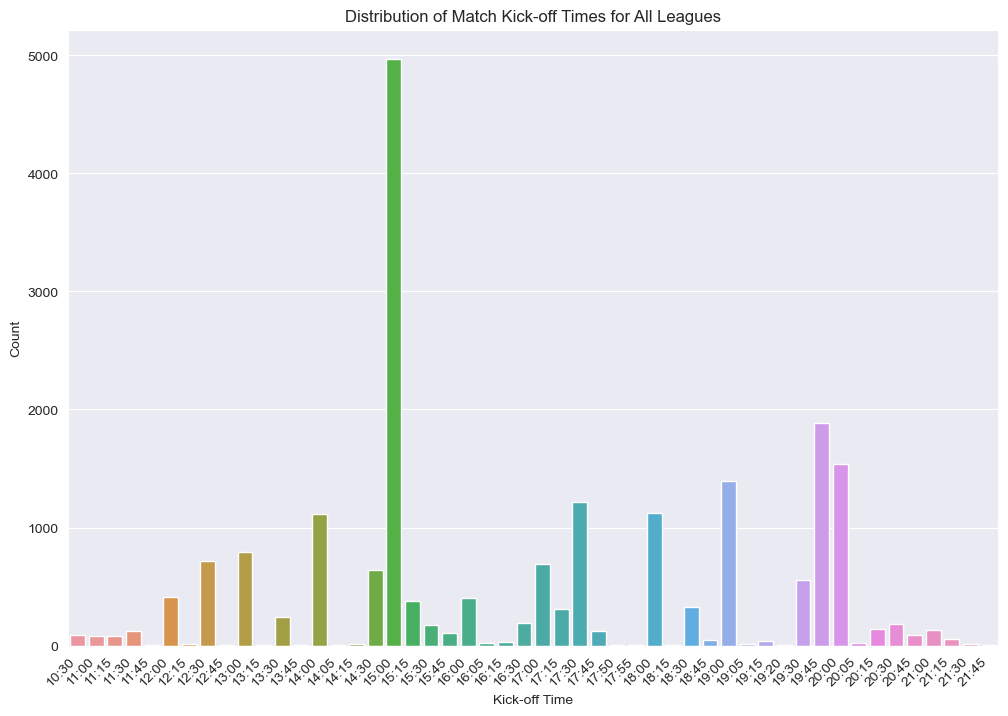

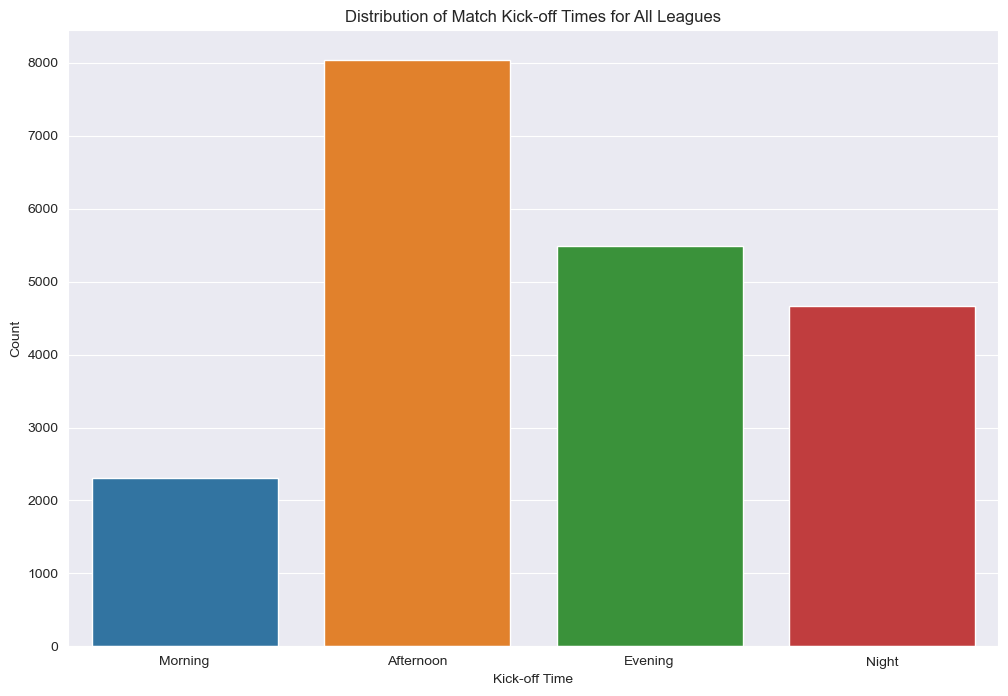

In [638]:
plot_time_distribution(train_df, "Distribution of Match Kick-off Times for All Leagues")
plot_time_bins_distribution(train_df, "Distribution of Match Kick-off Times for All Leagues")

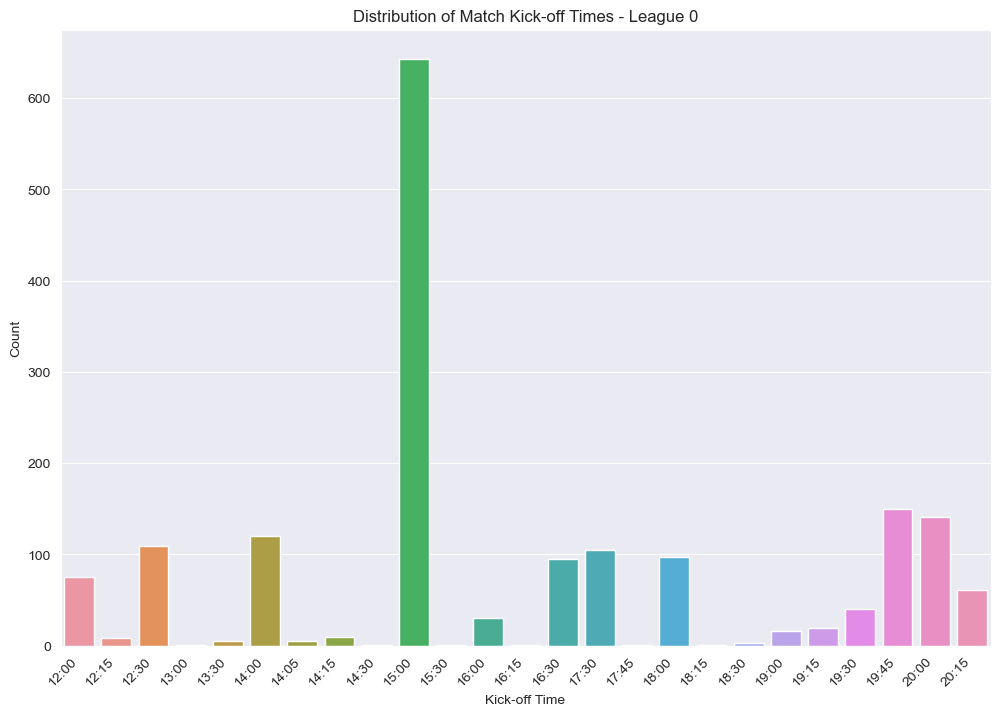

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/24328025.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_bin'] = pd.cut(df['Time_of_match_kick_off'], bins=bin_edges, labels=time_bins)


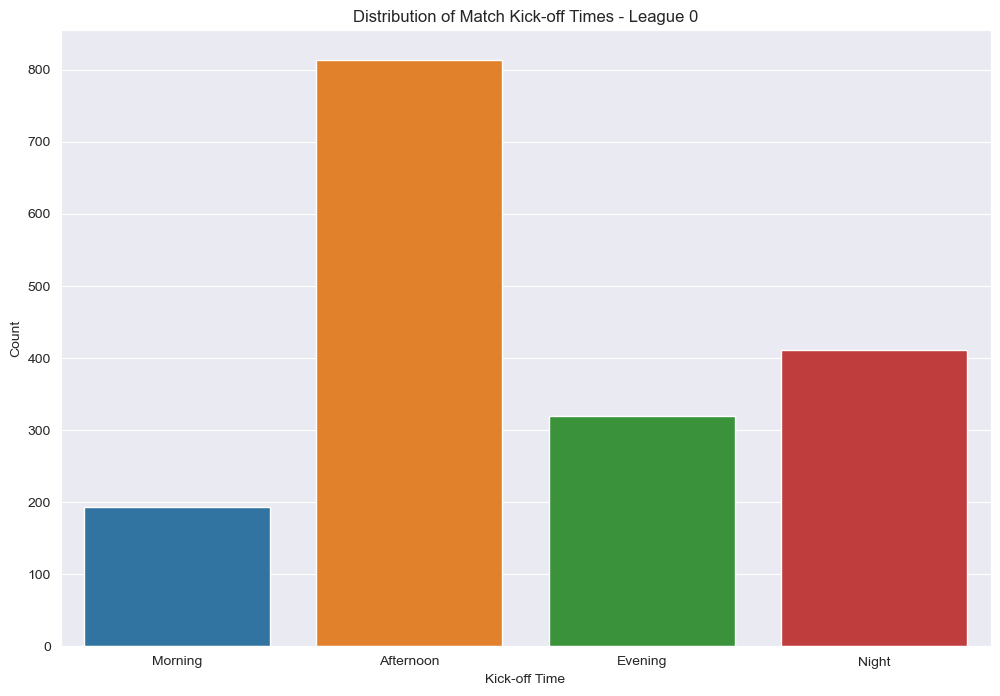

In [639]:
plot_time_distribution(df_league_0, f'Distribution of Match Kick-off Times - League 0')
plot_time_bins_distribution(df_league_0, f'Distribution of Match Kick-off Times - League 0')

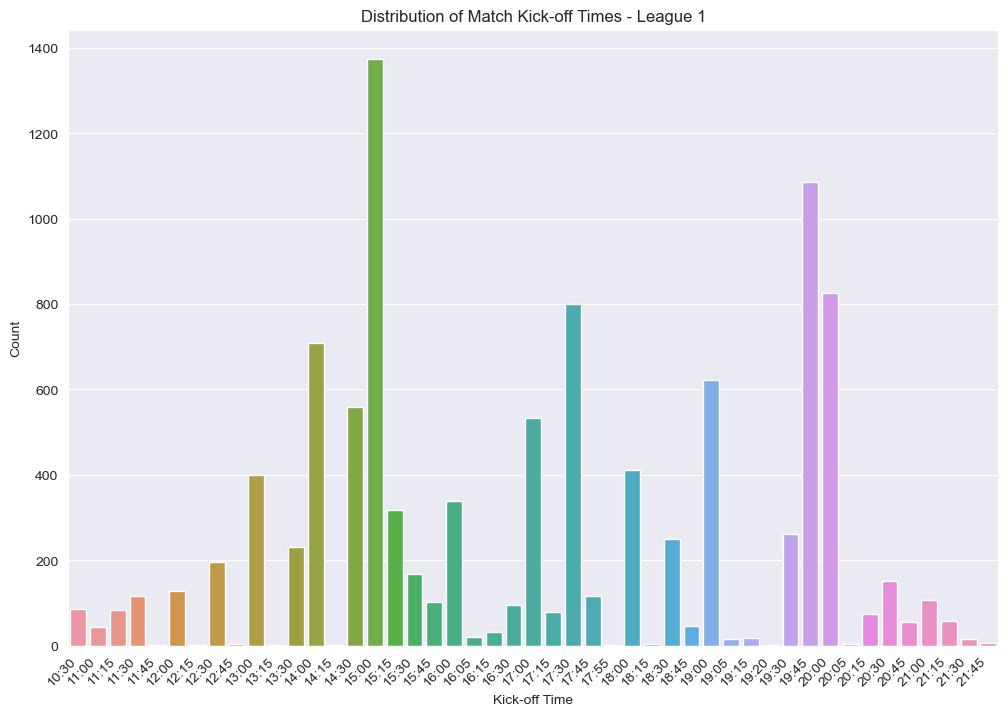

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/24328025.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_bin'] = pd.cut(df['Time_of_match_kick_off'], bins=bin_edges, labels=time_bins)


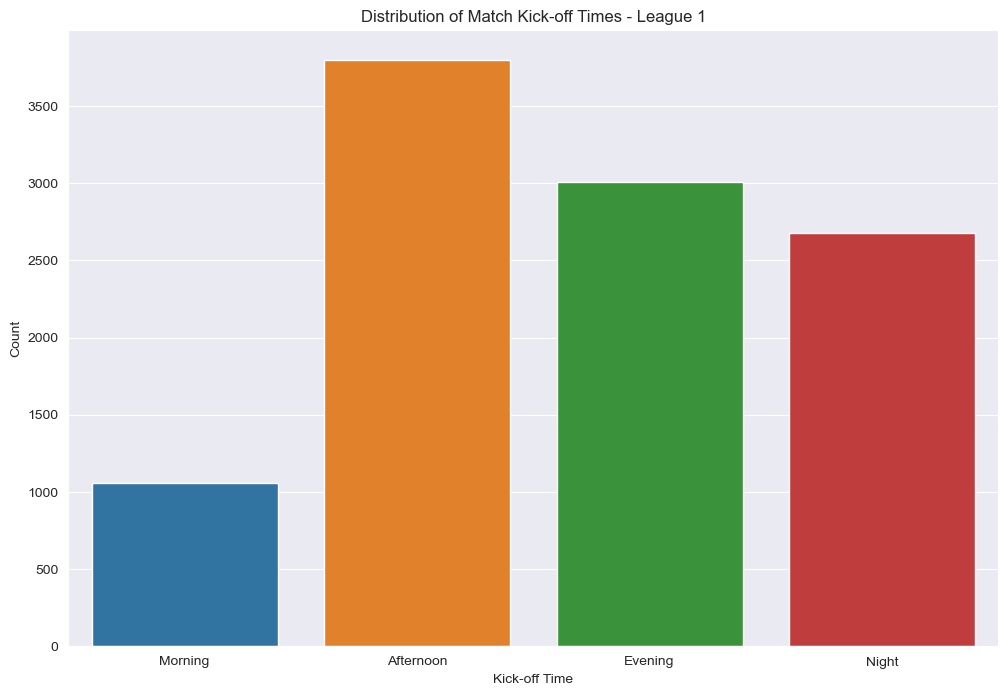

In [640]:
plot_time_distribution(df_league_1, f'Distribution of Match Kick-off Times - League 1')
plot_time_bins_distribution(df_league_1, f'Distribution of Match Kick-off Times - League 1')

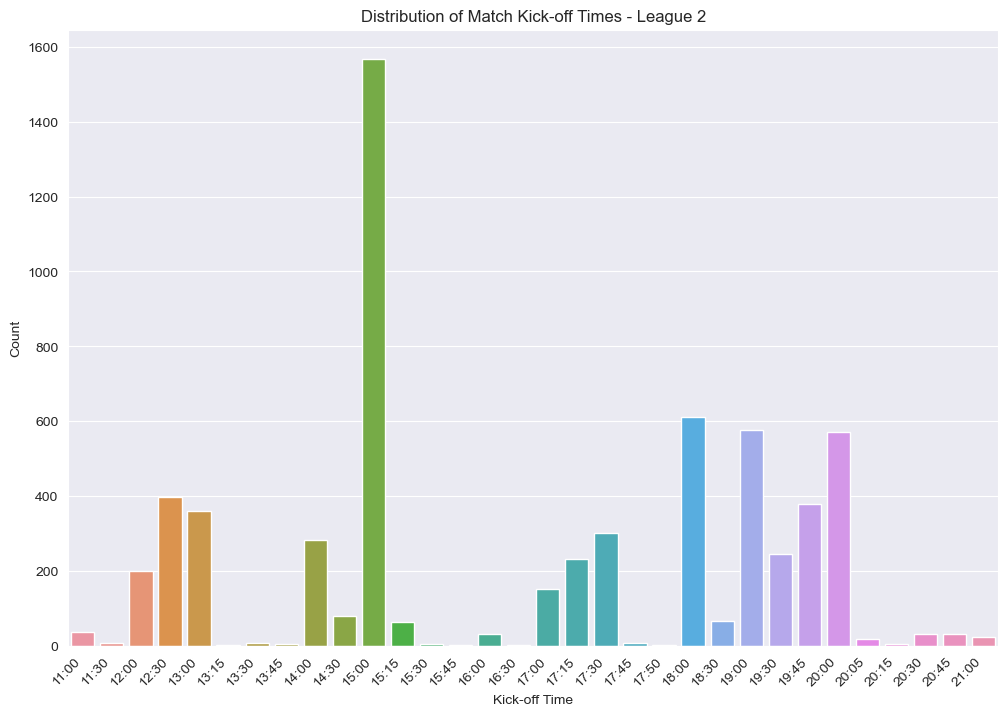

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/24328025.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_bin'] = pd.cut(df['Time_of_match_kick_off'], bins=bin_edges, labels=time_bins)


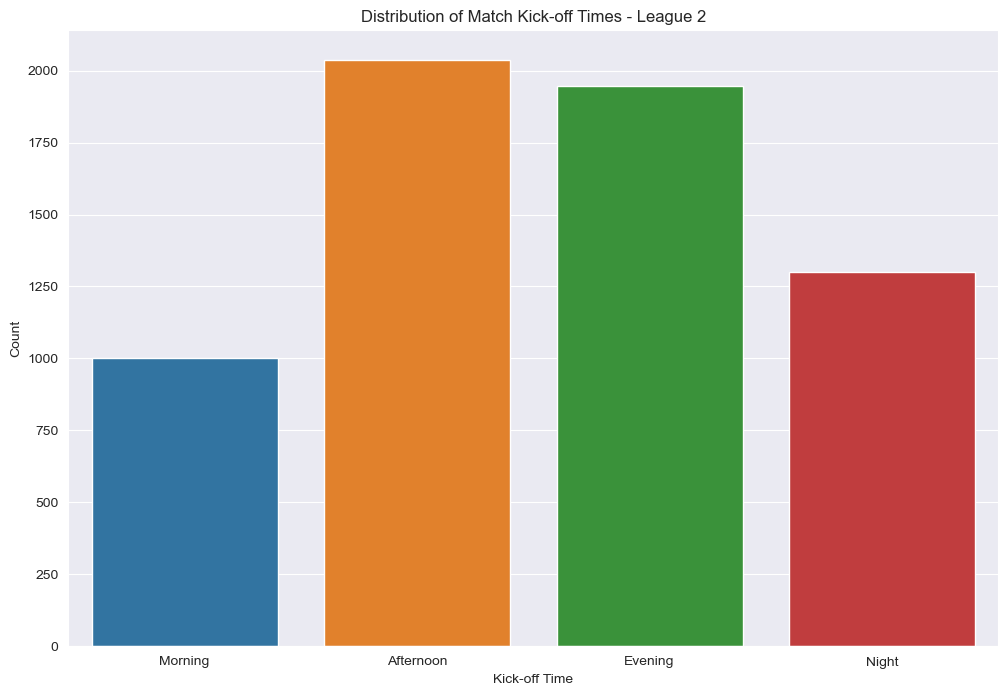

In [641]:
plot_time_distribution(df_league_2, f'Distribution of Match Kick-off Times - League 2')
plot_time_bins_distribution(df_league_2, f'Distribution of Match Kick-off Times - League 2')

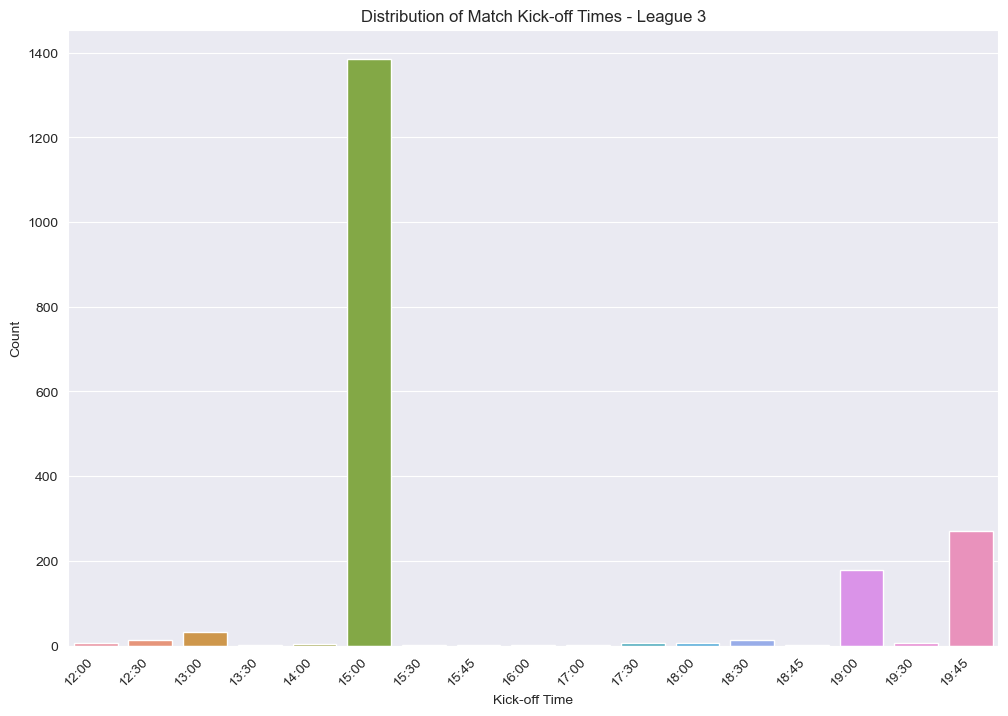

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/24328025.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time_bin'] = pd.cut(df['Time_of_match_kick_off'], bins=bin_edges, labels=time_bins)


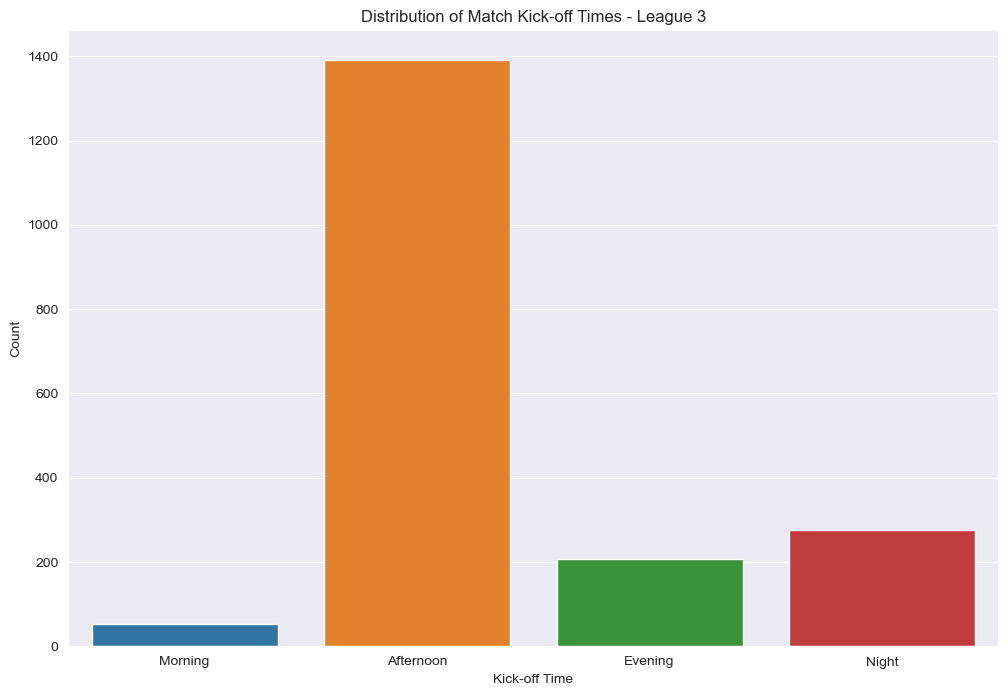

In [642]:
plot_time_distribution(df_league_3, f'Distribution of Match Kick-off Times - League 3')
plot_time_bins_distribution(df_league_3, f'Distribution of Match Kick-off Times - League 3')

In [643]:
def categorize_time(time_value):
    for i in range(len(bin_edges) - 1):
        if bin_edges[i] <= time_value < bin_edges[i + 1]:
            return time_bins[i]
    # If none of the bins match, return 'Afternoon'
    return 'Afternoon'


In [644]:
# Apply the function to create a new column 'Time_bin'
train_df['Time_bin'] = train_df['Time_of_match_kick_off'].apply(categorize_time)
train_df.drop(columns=['Time_of_match_kick_off'], inplace=True)

In [645]:
train_df['Time_bin'].isna().sum()

0

In [646]:
df_league_0['Time_bin'] = df_league_0['Time_of_match_kick_off'].apply(categorize_time)
df_league_0.drop(columns=['Time_of_match_kick_off'], inplace=True)

df_league_1['Time_bin'] = df_league_1['Time_of_match_kick_off'].apply(categorize_time)
df_league_1.drop(columns=['Time_of_match_kick_off'], inplace=True)

df_league_2['Time_bin'] = df_league_2['Time_of_match_kick_off'].apply(categorize_time)
df_league_2.drop(columns=['Time_of_match_kick_off'], inplace=True)

df_league_3['Time_bin'] = df_league_3['Time_of_match_kick_off'].apply(categorize_time)
df_league_3.drop(columns=['Time_of_match_kick_off'], inplace=True)

/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/1320325688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_league_0['Time_bin'] = df_league_0['Time_of_match_kick_off'].apply(categorize_time)
/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/1320325688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_league_0.drop(columns=['Time_of_match_kick_off'], inplace=True)
/var/folders/g3/b2rhcsbj74b0r5p3cjff117h0000gn/T/ipykernel_3317/1320325688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

## NA treatment

In [647]:
print_missing_values_summary(df_league_0, 0)


League: 0
Number of rows: 2927
                      column_name  NA_count  NA_percent
0                         Country         0        0.00
1                          League         0        0.00
2                          Season         0        0.00
3                 League_Division         0        0.00
4                      Match_Date         7        0.24
5                       Home_Team         0        0.00
6                       Away_Team         0        0.00
7       Full_Time_Home_Team_Goals         7        0.24
8       Full_Time_Away_Team_Goals         0        0.00
9                Full_Time_Result         0        0.00
10      Half_Time_Home_Team_Goals         0        0.00
11      Half_Time_Away_Team_Goals         0        0.00
12               Half_Time_Result        11        0.38
13                      DayOfWeek         7        0.24
14                        Weekend         0        0.00
15                Home_Team_Shots         0        0.00
16              

Drop columns with more than 80% missing values, and drop the rest of the missing values.

In [649]:
columns_to_drop = [
    'League_Division', 'Half_Time_Home_Team_Goals', 'Half_Time_Away_Team_Goals', 'Half_Time_Result', 
    'Home_Team_Free_Kicks_Conceded', 'Away_Team_Free_Kicks_Conceded', 'Crowd_Attendance',
    'Match_Referee', 'Home_Team_Hit_Woodwork', 'Away_Team_Hit_Woodwork', 
    'Home_Team_Offsides', 'Away_Team_Offsides', 'Home_Team_Bookings_Points',
    'Away_Team_Bookings_Points'
]
train_df = train_df.drop(columns=columns_to_drop, axis=1)
df_league_0 = df_league_0.drop(columns=columns_to_drop, axis=1)
df_league_1 = df_league_1.drop(columns=columns_to_drop, axis=1)
df_league_2 = df_league_2.drop(columns=columns_to_drop, axis=1)
df_league_3 = df_league_3.drop(columns=columns_to_drop, axis=1)

In [650]:
train_df = train_df.dropna()
df_league_0 = df_league_0.dropna()
df_league_1 = df_league_1.dropna()
df_league_2 = df_league_2.dropna()
df_league_3 = df_league_3.dropna()